<a href="https://colab.research.google.com/github/silverstar0727/1day-1commit-challenge/blob/master/bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# google drive와 연동
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# 연동 테스트 코드
with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')

!cat /content/gdrive/My\ Drive/foo.txt

Hello Google Drive!

In [0]:
import numpy as np
import pandas as pd

import seaborn as sns

In [14]:
df = pd.read_csv("/content/gdrive/My Drive/crypto_data/LTC-USD.csv", names = ['time', 'low', 'high', 'open', 'close', 'volume'])
df

,time,low,high,open,close,volume
0,1528968660,96.580002,96.589996,96.589996,96.580002,9.647200
1,1528968720,96.449997,96.669998,96.589996,96.660004,314.387024
2,1528968780,96.470001,96.570000,96.570000,96.570000,77.129799
3,1528968840,96.449997,96.570000,96.570000,96.500000,7.216067
4,1528968900,96.279999,96.540001,96.500000,96.389999,524.539978
...,...,...,...,...,...,...
101878,1535215020,58.009998,58.020000,58.020000,58.009998,7.301921
101879,1535215080,58.009998,58.020000,58.009998,58.020000,23.802017
101880,1535215140,58.020000,58.020000,58.020000,58.020000,6.953497
101881,1535215200,58.020000,58.080002,58.020000,58.080002,202.403183


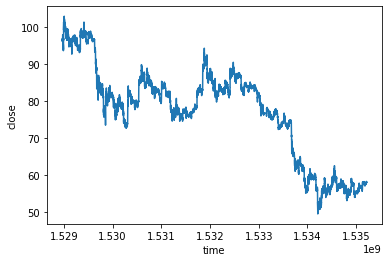

In [15]:
sns.lineplot(x = 'time', y = 'close', data = df)

In [0]:
# 데이터를 넣을 빈 데이터프레임을 만듦
main_df = pd.DataFrame()

In [0]:
#파라미터를 변수로 설정
SEQ_LEN = 60 # 몇분짜리를 한 덩어리로 학습시킬건지 (ex 60분)
FUTURE_PERIOD_PREDICT = 3 #몇 분 후 가격을 기준으로 등락을 결정할 건지 (3분 후)
RATIO_TO_PREDICT = "LTC-USD" # 어느 코인 가격을 예측?

In [20]:
ratios = ["BTC-USD", "LTC-USD", "ETH-USD"]
for ratio in ratios:
    dataset = f'/content/gdrive/My Drive/crypto_data/{ratio}.csv'
    df = pd.read_csv(dataset, names=['time','low','high','open','close','volume'])

    df.rename(columns={"close": f"{ratio}_close", "volume" : f"{ratio}_volume"}, inplace=True)


    # 일단 time을 index로 두고, 컬럼은 종가와 거래량만 남김
    df.set_index("time", inplace=True)
    df = df[[f"{ratio}_close", f"{ratio}_volume"]]
    # 그리고 이것들을 join한다 -> 여러 코인 데이터를 하나의 df에 join
    if len(main_df)==0:
        main_df = df
    else:
        main_df = main_df.join(df)

main_df.fillna(method="ffill",inplace=True)
main_df.dropna(inplace=True)
print(main_df.head())


## target값,즉 등락을 표시하기 위한 함수
def classify(current, future): #현재와 미래 가격을 인자로 받아서
    if float(future) > float(current):
        return 1 # 오르면 1
    else:
        return 0 # 떨어지면 0

#여기서 미래의 가격이란 3분 후의 가격
main_df['future'] = main_df[f'{RATIO_TO_PREDICT}_close'].shift(-FUTURE_PERIOD_PREDICT)
#그래서 위의 classfy 함수를 돌려 target value를 구한다
main_df['target'] = list(map(classify, main_df[f'{RATIO_TO_PREDICT}_close'], main_df['future']))


# test train split
#시간순으로 마지막 5%에 해당하는 데이터를 테스트 데이터로 쓴다
times = sorted(main_df.index.values) # get the times
last_5pct = sorted(main_df.index.values)[-int(0.05*len(times))]

# validation_main_df는 마지막 5% 이내 시간
validation_main_df = main_df[(main_df.index >= last_5pct)]
# main_df는 앞의 95% 시간에 해당하는 데이터가 들어감
main_df = main_df[(main_df.index < last_5pct)]

            BTC-USD_close  BTC-USD_volume  ...  ETH-USD_close  ETH-USD_volume
time                                       ...                               
1528968720    6487.379883        7.706374  ...      486.01001       26.019083
1528968780    6479.410156        3.088252  ...      486.00000        8.449400
1528968840    6479.410156        1.404100  ...      485.75000       26.994646
1528968900    6479.979980        0.753000  ...      486.00000       77.355759
1528968960    6480.000000        1.490900  ...      486.00000        7.503300

[5 rows x 6 columns]


In [0]:
from sklearn import preprocessing
from collections import deque
import random

In [0]:
def preprocess_df(df):
    df = df.drop("future", axis=1) #필요없는 컬럼은 제거 (왜 위에서 안 지웠지?)

    #코인마다 가격이 닫르므로 스케일링을 해주어야 합니다.
    #여기서는 percent chnage를 하고 다시 sklearn.preprocessing.scale를 썼는디
    #구체적으로 어떤식으로 스케일링을 하는지는 찾아보지 않았습니다.
    for col in df.columns:
        if col != "target":
            df[col] = df[col].pct_change() #퍼센트 체인지
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)

    # sentdex가 na는 잘 생긴다고 안전빵으로 dropna 한다고 했습니다.
    df.dropna(inplace=True)

    #자 이제 한 묶음으로 때려넣을 데이터를 묶습니다.
    sequential_data = []
    #deque는 배열에 새로운 데이터가 들어와도 length를 유지해주는 친구입니다.
    #배열이 꽉 찼는데 새로 뭐가 들어오면 맨 뒤에는 팅겨나가는 방식으로
    #크기를 유지합니다. 여기서는 SEQ_LEN, 즉 60개가 배열 크기가 됩니다.
    prev_days = deque(maxlen=SEQ_LEN)


    for i in  df.values:
        prev_days.append([n for n in i[:-1]]) #타겟 빼놓고 나머지를 pre_days에 어펜드
        if len(prev_days) == SEQ_LEN: #pre_days에 60개가 꽉차면
            sequential_data.append([np.array(prev_days),i[-1]]) #sequential_data에 target과 함께 어펜드
    random.shuffle(sequential_data)


    ## blancing
    # target이 1이면 사라, 0이면 팔아라,의 신호인데
    # 데이터 불균형이 있을 수 있으므로 그것을 맞추는 작업
    buys = []
    sells = []

    for seq, target in sequential_data:
        #타겟이 0이면 팔아라에 넣고
        if target == 0:
            sells.append([seq, target])
        #타겟이 1이면 사라에 넣는다
        elif target == 1:
            buys.append([seq, target])

    random.shuffle(buys)
    random.shuffle(sells)

    # 두 데이터의 숫자를 맞춰주려고 함(둘 중 숫자가 작은 것으로)
    lower = min(len(buys), len(sells))

    #위에서 미리 셔플해놨으므로 그냥 슬라이싱 하면 됨.
    buys = buys[:lower]
    sells = sells[:lower]

    # 둘을 합쳐서 학습 데이터에 넣고
    sequential_data = buys+sells
    random.shuffle(sequential_data)

    # test train split
    X = []
    y = []

    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)

    return np.array(X), y


In [0]:
train_x, train_y = preprocess_df(main_df)
validation_x, validation_y = preprocess_df(validation_main_df)

In [0]:
import time
EPOCHS = 10
BATCH_SIZE=64

#요거는 로그를 저장할 때 쓸 이름입니다.
#하이퍼 파라미터를 이름에 들어가게 하는 건 좋은 방법인 것 같아요.
#시간도 집어넣어서 겹치는 일이 없도록 합니다.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

In [25]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
!pip install 

In [26]:
model = Sequential()

model.add(CuDNNLSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2)) #오버피팅을 막고자 일부를 버림
model.add(BatchNormalization())

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

opt = Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

ModuleNotFoundError: ignored